# Trabajo práctico 1 - Simulación

In [ ]:
import sys
!{sys.executable} -m pip install scipy

import matplotlib.pyplot as plt
from collections import Counter
from random import random
import math
import scipy.stats as st
import numpy as np

## Ejercicio 1

1- Utilizando Matlab, Octave o Python implementar un Generador Congruencial Lineal (GCL) de módulo 2^32, multiplicador 1013904223, incremento de 1664525 y semilla igual a la parte entera de la suma ponderada (0,15-0,25-0,6) de los números de padrón de los integrantes del grupo, ordenados ascendentemente.
* Informar los primeros 5 números de la secuencia.
* Modificar el GCL para que devuelva números al azar entre 0 y 1, y realizar un histograma sobre 100.000 valores generados.

Primero, definiermos dos funciones que usaremos durante gran parte del trabajo práctico: un generador congruencial lineal genérico, que permita pasarle los parámetros que necesitamos, y una función que genere plots con los valores, titulo y ejes que querramos.

In [ ]:
def GCL(multiplier, seed, increment, module, generated_length):
    l = [(multiplier * seed + increment) % module]
    for i in range(1, generated_length):
        l.append( (multiplier * l[i-1] + increment) % module)
    return l

def plot_values(histogram_values, title, x_label, y_label, num_bins = 100, relative_frequency = 0):
    fig, ax = plt.subplots()

    if(relative_frequency):
        gcl_histogram = plt.hist(histogram_values, bins = num_bins, weights=np.zeros_like(histogram_values) + 1. / len(histogram_values))
    else:
        n, bins, patches = ax.hist(histogram_values, num_bins, density=1)
        gcl_histogram = plt.hist(histogram_values, bins = num_bins)

    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    
    plt.show()

In [ ]:
seed = int(99136 * 0.15 + 92308 * 0.25 + 97092 * 0.6)

def GCL_ej1(generated_length):
    return GCL(1013904223, seed, 1664525, 2 ** 32, generated_length)

five_numbers = GCL_ej1(5)
five_numbers

In [ ]:
histogram_values = list(map(lambda x: x/(2 ** 32), GCL_ej1(100000)))

In [ ]:
plot_values(histogram_values, 'GCL histogram plot', 'Values', 'Number of occurrences')

Se puede observar que el gráfico respeta la forma de un generador uniforme. No hay valores que se repitan mucho más o menos que la media.

## Ejercicio 2

Utilizando el generador de números aleatorios con distribución uniforme [0,1] implementado en el ejercicio 1 y utilizando el método de la transformada inversa genere números pseudoaleatorios con distribución exponencial negativa de media 20.
* Realizar un histograma de 100.000 valores obtenidos.
* Calcular la media y varianza de la distribución obtenida y compararlos con los valores teóricos.

In [ ]:
def inversa_exponencial(random_value, lambda_value = 1):
    return (-1/lambda_value) * math.log(1 - random_value)

lambda_value = 1/20


histogram_values = list(map(lambda x: x/(2 ** 32), GCL_ej1(100000)))
exponencial_values = list(map(lambda x: inversa_exponencial(x, lambda_value), histogram_values))

plot_values(exponencial_values, 'Exponential histogram plot', 'Values', 'Number of occurrences')

Si en vez de utilizar el generador GCL del punto uno, usamos el generador random de python, podemos observar que el grafico es extremadamente similar.

In [ ]:
# This are the values generated with the random function from python.
exponencial_values_python = [inversa_exponencial(random(), lambda_value) for _ in range(100000)]

plot_values(exponencial_values_python, 'Exponential histogram plot (random from python)', 'Values', 'Number of occurrences')

Ahora calculemos la esperanza y la varianza de los valores generados a partir del GCL. Para ello, usaremos la librería numpy.

In [ ]:
exponential_mean = np.mean(exponencial_values)
exponential_standard_deviation = np.std(exponencial_values)
print("Esperanza: ", exponential_mean)
print("Varianza: ", exponential_standard_deviation ** 2)

Los valores obtenidos son muy similares a los valores teóricos esperados (deberían ser 20 la esperanza y 400 la varianza).

## Ejercicio 3

Utilizando el método de Box-Muller genere de números aleatorios con distribución normal standard.
* Realizar un histograma de 100.000 valores obtenidos.
* Calcular la media y varianza de la distribución obtenida y compararlos con los valores teóricos.

El método box muller genera dos valores con distribución normal a partir de dos valores uniformes. Para generar los 100.000 valores, utilizamos el método random de python, y llamamos 50.000 veces a la función box_muller. Como se puede observar en el gráfico, respeta la campana de una distribución normal centrada en el 0 y con varianza 1.

In [ ]:
def box_muller(u1, u2):
    z1 = math.sqrt(-2 * math.log(u1)) * math.cos(2 * math.pi * u2)
    z2 = math.sqrt(-2 * math.log(u1)) * math.sin(2 * math.pi * u2)
    return z1,z2

def normal_box_muller(iterations):
    normal_values = []
    for _ in range(iterations):
        normal_values_tuple = box_muller(random(), random())
        normal_values.append(normal_values_tuple[0])
        normal_values.append(normal_values_tuple[1])
    return normal_values
        
normal_values = normal_box_muller(50000)

plot_values(normal_values, 'Normal (Box-Muller) histogram plot', 'Values', 'Number of occurrences')

Ahora calculemos la esperanza y la varianza de los valores generados a partir de la función Box Muller. Para ello, usaremos la librería numpy.

In [ ]:
normal_mean = np.mean(normal_values)
normal_standard_deviation = np.std(normal_values)
print("Esperanza: ", normal_mean)
print("Varianza: ", normal_standard_deviation ** 2)

Los valores obtenidos son muy similares a los esperados (esperanza 0 y varianza 1).

## Ejercicio 4

Genere 100.000 número aleatorios condistribución Normal de media 40 y desvío estándar 6 utilizando el algoritmo de Aceptación y Rechazo.
* Realizar un histograma de frecuencias relativas con todos los valores obtenidos.
* Comparar, en el mismo gráfico, el histograma realizado en el punto anterior con la distribución normal brindada por Matlab, Octave o Python.
* Calcular la media y la varianza de la distribución obtenida y compararlos con los valores teóricos.

Vamos a generar una normal estandard X(t) que luego vamos a desplazarla y expandirla para obtener una normal de media 40 y desvío 6.

Podemos generar los valores positivos de X(t) y luego multiplicar la mitad de ellos por -1, obteniendo la generación del resto de la curva.

Proponemos una distribución exponencial con lambda = 1 que la llamaremos Y(t), mientras que queremos generar X(t) que es la distribución normal estándar.

1- Necesitamos encontrar una cota superior c, tal que, c >= X(t)/Y(t)
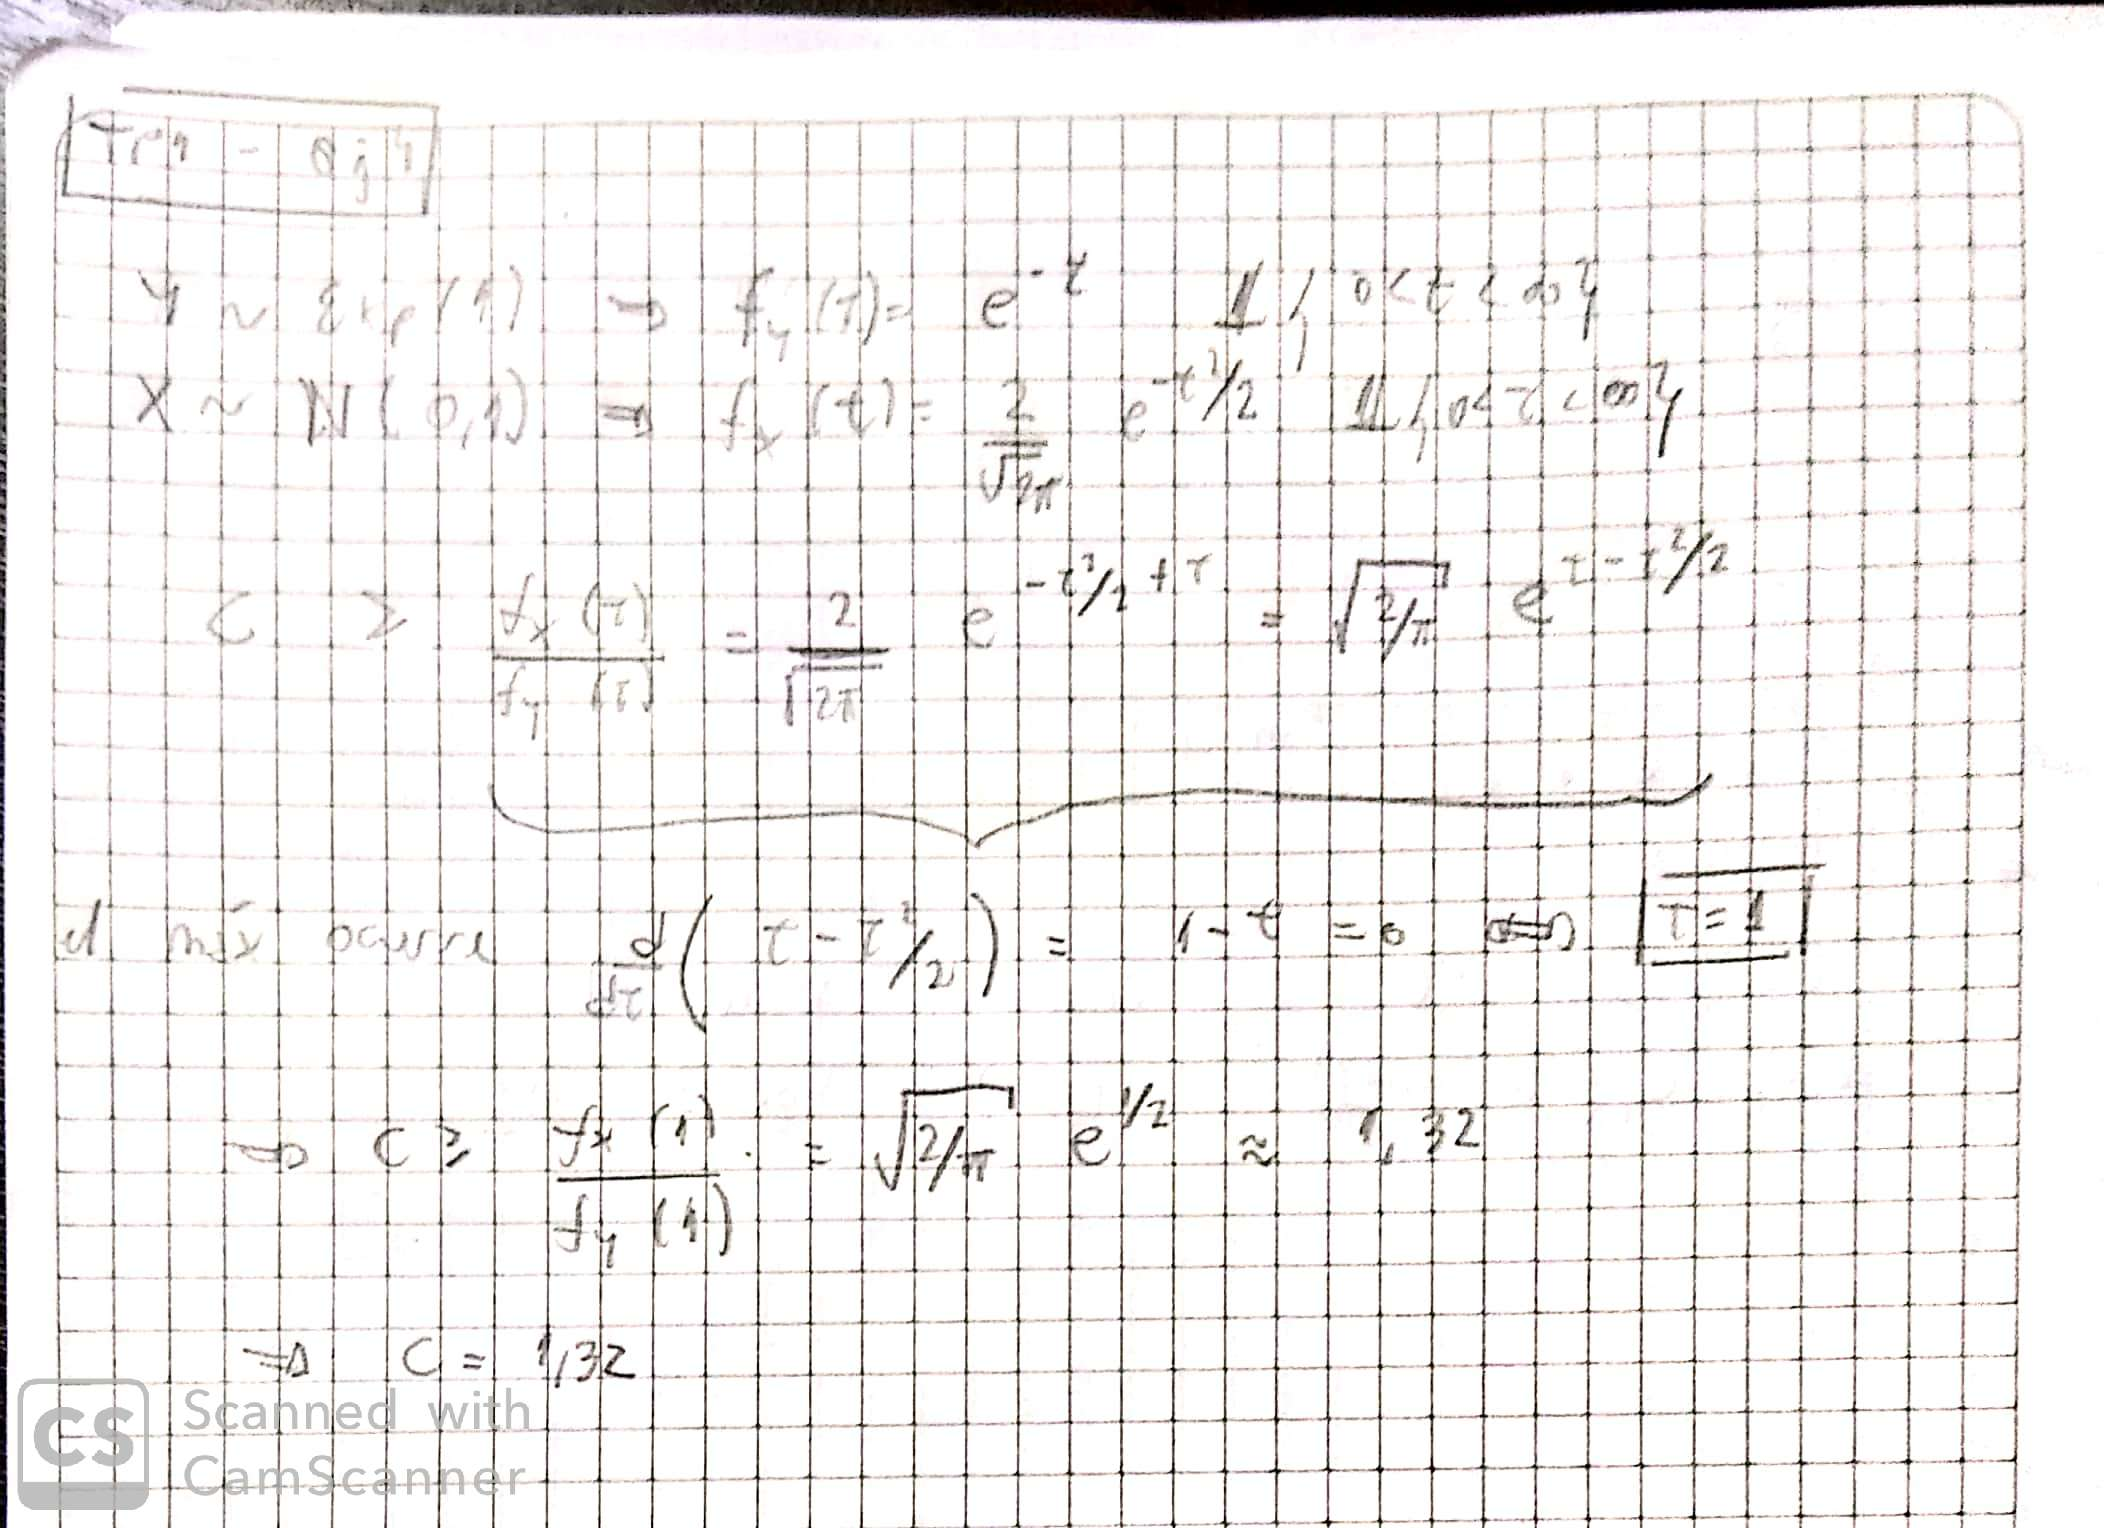

2- Sabiendo que c=1.32, entonces generamos un número al azar de Y(t) con inversa_exponencial(x, lambda_value) que lo llamaremos a

3- Generamos un número al azar entre 0 y 1 que lo llamaremos u

4- Si u <= X(a)/c*Y(a) entonces a es el valor generado, sino volvemos a 2

In [ ]:
def accept_reject_method_half_normal(iteraciones):
    l = []
    c = 1.32
    while (len(l) < iteraciones):
        a = inversa_exponencial(random(), 1)
        u = random()
        x = (math.sqrt(2 / math.pi)) * math.exp( a - (a ** 2)/2 )
        if (u <= x / c):
            l.append(a)
    return l

accept_reject_normal_positive_values = accept_reject_method_half_normal(50000)
plot_values(accept_reject_normal_positive_values, 'Positive Normal (Accept-Reject Algorithm) histogram plot', 'Values', 'Number of occurrences')

Notamos que efectivamente tenemos la mitad de una normal estándar. Ahora lo que hacemos ese generar la otra mitad.

In [ ]:
def accept_reject_method_normal(iteraciones):
    l = []
    c = 1.32
    while (len(l) < iteraciones):
        a = inversa_exponencial(random(), 1)
        u = random()
        x = (math.sqrt(2 / math.pi)) * math.exp( a - (a ** 2)/2 )
        if (u <= x / c):
            if(random() < 0.5):
                l.append(-a)
            else:
                l.append(a)
    return l

accept_reject_normal_values = accept_reject_method_normal(100000)
plot_values(accept_reject_normal_values, 'Normal Standard (Accept-Reject Algorithm) histogram plot', 'Values', 'Number of occurrences')

Ahora podemos desplazar y ensanchar esta normal multiplicando los valores obtenidos por el desvío 6 y la media 40

In [ ]:
mu = 40
desvío = 6

normal_values_ej4 = list(map(lambda x: (x * desvío) + mu, accept_reject_normal_values))
plot_values(normal_values_ej4, 'Normal (Accept-Reject Algorithm) histogram plot', 'Values', 'Number of occurrences')

1) En consecuencia, obtenemos el histograma de frecuencias relativas:

In [ ]:
plot_values(normal_values_ej4,'Normal (Accept-Reject Algorithm) histogram plot', 'Values', 'Relative frequency', relative_frequency=1 )

2) Se puede observar que tanto en el histograma del ejercicio anterior como en el histograma de este ejericio, la cantidad de observaciones ocurridas en la media son similiares (cerca de las 35.000 ocurrencias) aunque de manera muy notable se puede observar el desplazamiento y el ensanchamiento de la normal de este ejercicio.

In [ ]:
plt.hist(normal_values, 100, alpha=0.5, label='Ej. 3')
plt.hist(normal_values_ej4, 100, alpha=0.5, label='Ej. 4')
plt.legend(loc='upper right')
plt.show()

3) La media teórica de esta distribución es 40 y la varianza 6:

In [ ]:
accept_reject_normal_mean = np.mean(normal_values_ej4)
accept_reject_normal_deviation = np.std(normal_values_ej4)
print("Esperanza: ", accept_reject_normal_mean)
print("Varianza: ", accept_reject_normal_deviation ** 2)

Que son valores muy similares a los teóricos.

## Ejercicio 5
Utilizando el método de la transformada inversa y utilizando el generador de números aleatorios implementado en el ejercicio 1 genere números aleatorios siguiendo la siguiente función de distribución de probabilidad empírica.

    Probabilidad     Valor generado

     .4                 1

     .3                 2

     .12                3

     .1                 4

     .08                5
     
Muestre los resultados obtenidos en un histograma.

In [ ]:
def transform_values_to_discrete_distribution(u):
    if (u <= 0.4):
        return 1
    elif (u <= 0.7):
        return 2
    elif (u <= 0.82):
        return 3
    elif (u <= 0.92):
        return 4
    else:
        return 5

ej1_values = list(map(lambda x: x/(2 ** 32), GCL_ej1(100000)))
discrete_values = list(map(lambda x: transform_values_to_discrete_distribution(x), ej1_values))

plot_values(discrete_values, 'Discrete histogram plot', 'Values', 'Number of occurrences', num_bins = 5)

Para lograr mayor claridad, mostraremos la cantidad de valores obtenidos y la cantidad teórica que deberíamos haber obtenido.

In [ ]:
number_of_values = Counter(discrete_values)
print("Cantidad de 1: ", number_of_values[1], ". Cantidad teórica: 40.000")
print("Cantidad de 2: ", number_of_values[2], ". Cantidad teórica: 30.000")
print("Cantidad de 3: ", number_of_values[3], ". Cantidad teórica: 12.000")
print("Cantidad de 4: ", number_of_values[4], ". Cantidad teórica: 10.000")
print("Cantidad de 5: ", number_of_values[5], ". Cantidad teórica: 8000")

Como se puede observar, los valores obtenidos son muy similares a los teóricos esperados

## Ejercicio 6
Utilizando 2 generadores de números al azar, provistos por el lenguaje elegido para resolver el tp, con distribuciones uniformes en [-1,1] genere números aleatorios en un círculo de radio 1 centrado en el origen.
Muestre el resultado en un gráfico de 2 dimensiones.

In [ ]:
def circle_point():
    angle = random() * math.pi * 2
    distance_to_center = random()
    x = math.cos(angle) * distance_to_center
    y = math.sin(angle) * distance_to_center
    return (x, y)
    
x_points = []
y_points = []
for _ in range(10000):
    x, y = circle_point()
    x_points.append(x)
    y_points.append(y)

    
plt.scatter(x_points, y_points, s = 1)
plt.show()

Los puntos tienen dos valores random: la distancia al centro del círculo y el ángulo. Como consecuencia de esto, se puede observar que hay una mayor concentración de puntos en el centro ya que a medida que aumenta la distancia al centro la misma variación de ángulo separa más los puntos.

## Ejercicio 7
Realizar, sólo gráficamente, un test espectral en 2 y 3 dimensiones al generador conguencial lineal implementado en el ejercicio 1. ¿Cómo se distribuyen espacialmente los puntos obtenidos?

In [ ]:
generated_length = 100000
values_from_excersice_1 = GCL_ej1(generated_length)

x_values = []
y_values = []
for i in range(1,generated_length):
    x_values.append(values_from_excersice_1[i])
    y_values.append(values_from_excersice_1[i-1])

plt.scatter(x_values, y_values, s = 0.02)
plt.show()

A simple vista no se puede apreciar nada. Pero si hacemos zoom?

In [ ]:
figzoom, axzoom = plt.subplots()

axzoom.scatter(x_values, y_values, s=1)

#axzoom.set_ylim(2500000000, 3000000000)
axzoom.set_xlim(2990000000, 3000000000)

plt.show()

Luego de realizar diferentes tipos de zoom tanto en x como en y, no pudimos encontrarse ningún patrón

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

x_values = []
y_values = []
z_values = []
for i in range(2,generated_length):
    x_values.append(values_from_excersice_1[i])
    y_values.append(values_from_excersice_1[i-1])
    z_values.append(values_from_excersice_1[i-2])


ax.scatter(x_values, y_values, z_values, s = 0.02)

ax.set_xlabel('x(n)')
ax.set_ylabel('x(n-1)')
ax.set_zlabel('x(n-2)')

plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

x_values = []
y_values = []
z_values = []
for i in range(2,generated_length):
    x_values.append(values_from_excersice_1[i])
    y_values.append(values_from_excersice_1[i-1])
    z_values.append(values_from_excersice_1[i-2])


ax.scatter(x_values, y_values, z_values, s = 8)
#ax.set_xlim(2900000000, 3000000000)
ax.set_ylim(200000000, 400000000)
ax.set_zlim(2900000000, 3000000000)

ax.set_xlabel('x(n)')
ax.set_ylabel('x(n-1)')
ax.set_zlabel('x(n-2)')

plt.show()

Despues de hacer zoom en los 3 ejes, no se observa ningún patrón que indique alguna deficiencia en el GNL.

## Ejercicio 8

Realizar un test Chi 2 a la distribución empírica implementada en el Ej 5, analizar el resultado indicando si la distribución puede o no ser aceptada.

In [ ]:
from scipy import stats as stats
import matplotlib.mlab as mlab

ej1_values = list(map(lambda x: x/(2 ** 32), GCL_ej1(100000)))
discrete_values = list(map(lambda x: transform_values_to_discrete_distribution(x), ej1_values))
frecs = []
for i in range(5):
    frecs.append(0)
    for value in discrete_values:
        if value == i + 1:
            frecs[i] += 1
expected_values =  [0.4*100000,0.3*100000,0.12*100000,0.1*100000,0.08*100000]

'''“Delta degrees of freedom”: adjustment to the degrees of freedom for the p-value. The p-value is computed using a chi-squared distribution with k - 1 - ddof degrees of freedom, where k is the number of observed frequencies. The default value of ddof is 0.'''
degrees_of_freedom = 0.1


(s,p) = stats.chisquare(frecs,f_exp = expected_values, ddof = degrees_of_freedom)
print("s = " + str(s))
print("p = " + str(p))

if(1-p < degrees_of_freedom):
    print("Acepto H0")
else:    
    print("Rechazo H0")

Como p = 0.25 necesariamente voy a rechazar dicho test, ya que necesitaría un nivel de significacion demasiado alto para aceptarlo.

## Ejercicio 9
Al generador congruencial lineal implementado en el ejercicio 1 realizarle un gap test para el intervalo [0,2 - 0,5], analizar el resultado indicando si pasa el test.

Generamos y contamos las observaciones del GCL del ejercicio 1 y calculamos la probabilidades de la geómetrica usada para el Gap Test

In [ ]:
random_glc_probabilities = list(map(lambda x: x/(2 ** 32), GCL_ej1(100000)))
experimental_results = np.zeros(len(random_glc_probabilities))
pos = 0

for i in range(len(random_glc_probabilities)):
    if(random_glc_probabilities[i] >= 0.2 and random_glc_probabilities[i] <= 0.5):
        experimental_results[pos] = experimental_results[pos] + 1
        pos = 0
    else:
        pos = pos + 1

number_of_experiments = sum(experimental_results)
# Cortamos en 100, a más de 50 no llega.
experimental_results = experimental_results[:100]

probabilities = np.zeros(len(experimental_results))
probabilities[0] = 0.5 - 0.2
for i in range(1,len(experimental_results)):
    probabilities[i] = ((1 - probabilities[0]) ** i) * probabilities[0]

Una vez generadas, realizamos el test chi cuadrado:

In [ ]:
'''“Delta degrees of freedom”: adjustment to the degrees of freedom for the p-value. The p-value is computed using a chi-squared distribution with k - 1 - ddof degrees of freedom, where k is the number of observed frequencies. The default value of ddof is 0.'''
degrees_of_freedom = 0.1

obs = experimental_results
expected_values = probabilities * number_of_experiments
(s,p) = stats.chisquare(obs, f_exp = expected_values, ddof = degrees_of_freedom)
print("s = " + str(s))
print("p = " + str(p))

if(1-p < degrees_of_freedom):
    print("Acepto H0")
else:    
    print("Rechazo H0")

El resultado es que la hipótesis se acepta.

## Ejercicio 10
Aplicar el test de Kolmogorov-Smirnov al generador de números al azar con distribución normal generado en el ejercicio 3, y analizar el resultado del mismo.
Graficar la distribución acumulada real versus la distribución empírica.

In [ ]:
from scipy.stats import norm

iterations = 1000
normal_values = normal_box_muller(iterations)

def empirical_cdf(values, x):
    values.sort()
    n = len(values)
    
    for i in range(n):
        if( i == 0 and x < values[i+1] ):
            return 0
        elif( i >= n and x >= values[i] ):
            return 1
        elif( x >= values[i] and x < values[i+1] ):
            return i/n
        
N = len(normal_values)
normal_values.sort()
empirical_normal_values = [ empirical_cdf(normal_values, normal_values[i]) for i in range(N-1) ]
theoretical_normal_values = [ norm.cdf(normal_values[i]) for i in range(N-1) ]

d_plus = [ empirical_normal_values[i] - theoretical_normal_values[i]  for i in range(N-1) ]
d_minus = [ theoretical_normal_values[i] - empirical_normal_values[i]  for i in range(N-1) ]

d = max(d_plus) if max(d_plus) > max(d_minus) else max(d_minus)
d

In [ ]:
normal_values

Primero calculamos la funcion de distribución acumulada de la normal. 
Luego calcula la fda de la distribución teórica.
Por ultimo generamos el estadistico.

In [ ]:
fig, ax = plt.subplots()

ax.step(normal_values[:-1], empirical_normal_values, 'b', label='Empirical') 
ax.plot(normal_values[:-1], theoretical_normal_values, 'r', label='Theoretical') 

ax.set_title("Normal cdf empirical vs theoretical")
leg = ax.legend();

plt.show()

Realizando diferentes cantidad de iteraciones sobre el generador de números al azar con distribución normal generado en el ejercicio 3, se puede observar que a mayor cantidad de iteraciones, menor la diferencia entre ambas funciones de distribución acumulada